# TRANSFER LEARNING

✅ Device: cuda
✅ EuroSAT classes: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
✅ Using 16500 images for 3-class task.
✅ Total mapped distribution: Counter({0: 8000, 2: 5500, 1: 3000})
✅ Split sizes | Train: 11550 Val: 2475 Test: 2475
✅ Train mapped distribution: Counter({0: 5600, 2: 3850, 1: 2100})
✅ Class weights: [0.6875    1.8333334 1.       ]

=== Stage 1: Train head ===


/tmp/ipython-input-109762391.py:275: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if device == "cuda" else None


[Head] Epoch 01 | train 0.4231/0.8492 | val 0.3817/0.9107 | predDist [78 31 51]
[Head] Epoch 02 | train 0.3092/0.9259 | val 0.3354/0.9374 | predDist [85 30 45]

=== Stage 2: Fine-tune layer3+layer4+head ===
[FT]   Epoch 01 | train 0.2506/0.9589 | val 0.2582/0.9802 | best 0.9374 | predDist [82 29 49]
[FT]   Epoch 02 | train 0.2194/0.9783 | val 0.2459/0.9855 | best 0.9802 | predDist [82 29 49]
[FT]   Epoch 03 | train 0.2043/0.9857 | val 0.2346/0.9907 | best 0.9855 | predDist [83 28 49]
[FT]   Epoch 04 | train 0.1980/0.9889 | val 0.2313/0.9911 | best 0.9907 | predDist [83 29 48]
[FT]   Epoch 05 | train 0.1982/0.9881 | val 0.2304/0.9907 | best 0.9911 | predDist [83 29 48]

✅ Training done | Best Val Acc: 0.9911
✅ Saved best weights: best_resnet50_eurosat_3cls.pt
✅ Saved full checkpoint: best_resnet50_eurosat_3cls.pth

📌 TEST | Loss: 0.2390 | Acc: 0.9846


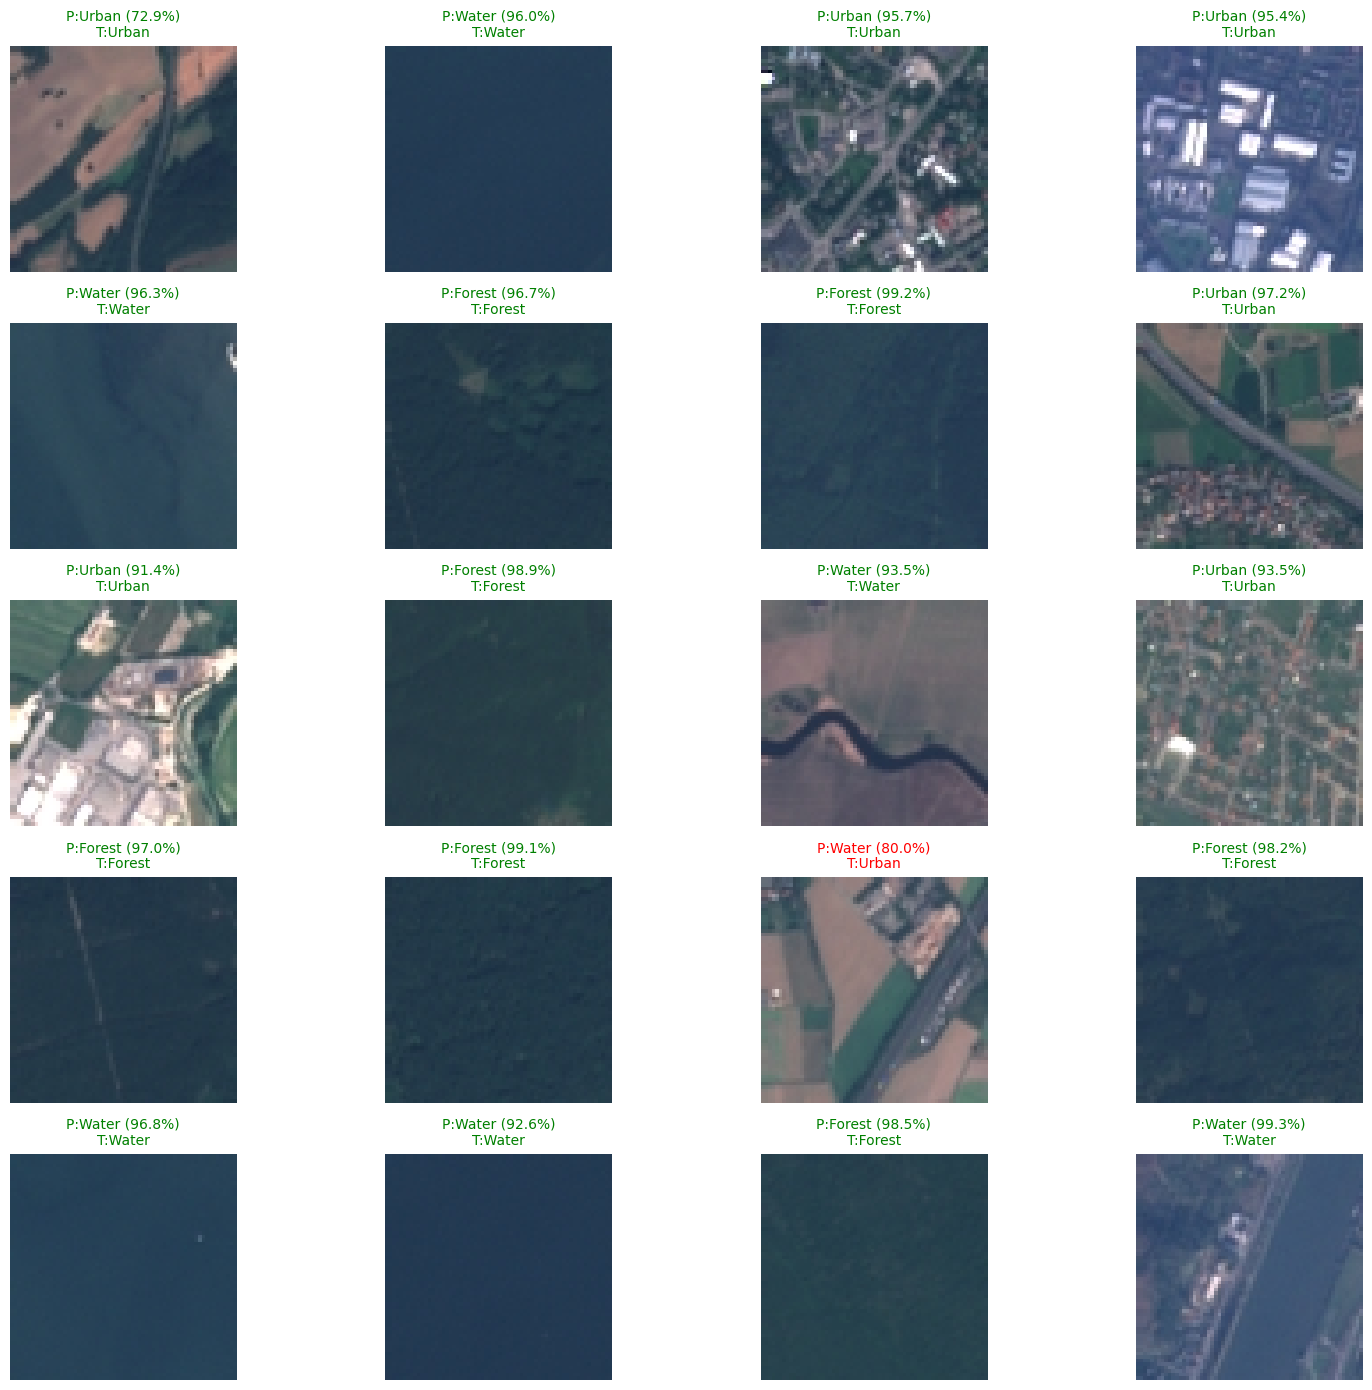


✅ FRONTEND READY (No rerun needed)
Run: upload_and_predict()  to upload and predict
Run: remove_uploaded()     to reset/remove old uploads


In [17]:
# =========================================================
# FULL COLAB READY: TRAIN + SAVE + TEST(20) + UPLOAD FRONTEND
# =========================================================

# --- installs (safe in Colab) ---
!pip -q install torch torchvision pillow matplotlib scikit-learn

import os, random, zipfile
from collections import defaultdict, Counter

import numpy as np
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import transforms
from sklearn.utils.class_weight import compute_class_weight
from PIL import Image
import matplotlib.pyplot as plt

from google.colab import files
from IPython.display import display, clear_output

# ----------------------------
# Config
# ----------------------------
SEED = 42
DATA_ROOT = "data"
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_WORKERS = 0              # safest in Colab
EPOCHS_HEAD = 2
EPOCHS_FT = 5

LR_HEAD = 5e-4
LR_FT_L3 = 1e-5
LR_FT_L4 = 1e-5
LR_FT_HEAD = 3e-4

WEIGHT_DECAY = 1e-4
GRAD_CLIP = 1.0

BEST_WEIGHTS_PATH = "best_resnet50_eurosat_3cls.pt"
BEST_CKPT_PATH    = "best_resnet50_eurosat_3cls.pth"

device = "cuda" if torch.cuda.is_available() else "cpu"
print("✅ Device:", device)

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = True

set_seed(SEED)

# ----------------------------
# Mapping: EuroSAT -> 3 classes
# ----------------------------
EUROSAT_TO_3 = {
    "Residential": 0,
    "Industrial": 0,
    "Highway": 0,
    "Forest": 1,
    "River": 2,
    "SeaLake": 2,
}
THREE_CLASS_NAMES = ["Urban", "Forest", "Water"]

# ----------------------------
# Transforms
# ----------------------------
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(12),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

val_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

# ----------------------------
# Load EuroSAT (PIL base)
# ----------------------------
base_ds = torchvision.datasets.EuroSAT(root=DATA_ROOT, download=True, transform=None)
class_names = base_ds.classes
name_by_idx = {i: n for i, n in enumerate(class_names)}
print("✅ EuroSAT classes:", class_names)

# ----------------------------
# Filter usable indices
# ----------------------------
kept_indices, kept_targets = [], []
for i in range(len(base_ds)):
    _, y = base_ds[i]
    cname = name_by_idx[y]
    if cname in EUROSAT_TO_3:
        kept_indices.append(i)
        kept_targets.append(EUROSAT_TO_3[cname])

print(f"✅ Using {len(kept_indices)} images for 3-class task.")
print("✅ Total mapped distribution:", Counter(kept_targets))

# ----------------------------
# Stratified train/val/test split
# ----------------------------
def stratified_split_3way(indices, labels, val_ratio=0.15, test_ratio=0.15, seed=42):
    random.seed(seed)
    by_class = defaultdict(list)
    for idx, lab in zip(indices, labels):
        by_class[lab].append(idx)

    train_idx, val_idx, test_idx = [], [], []
    for lab, idxs in by_class.items():
        random.shuffle(idxs)
        n = len(idxs)
        n_val = int(n * val_ratio)
        n_test = int(n * test_ratio)
        val_idx.extend(idxs[:n_val])
        test_idx.extend(idxs[n_val:n_val+n_test])
        train_idx.extend(idxs[n_val+n_test:])

    random.shuffle(train_idx); random.shuffle(val_idx); random.shuffle(test_idx)
    return train_idx, val_idx, test_idx

train_indices, val_indices, test_indices = stratified_split_3way(
    kept_indices, kept_targets, val_ratio=0.15, test_ratio=0.15, seed=SEED
)

print("✅ Split sizes | Train:", len(train_indices), "Val:", len(val_indices), "Test:", len(test_indices))

# ----------------------------
# Dataset wrapper: apply tfms + remap labels
# ----------------------------
class EuroSAT3Class(torch.utils.data.Dataset):
    def __init__(self, base_dataset, indices, tfms):
        self.base = base_dataset
        self.indices = indices
        self.tfms = tfms
        self.name_by_idx = {i: n for i, n in enumerate(self.base.classes)}

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, i):
        real_idx = self.indices[i]
        img, y = self.base[real_idx]
        cname = self.name_by_idx[y]
        y3 = EUROSAT_TO_3[cname]
        if self.tfms is not None:
            img = self.tfms(img)
        return img, y3

train_ds = EuroSAT3Class(base_ds, train_indices, train_tfms)
val_ds   = EuroSAT3Class(base_ds, val_indices, val_tfms)
test_ds  = EuroSAT3Class(base_ds, test_indices, val_tfms)

# ----------------------------
# BEST FIX: Balanced sampler (prevents "always Water")
# ----------------------------
# compute labels for train set without loading tensors
train_labels = []
for idx in train_indices:
    _, y = base_ds[idx]
    cname = name_by_idx[y]
    train_labels.append(EUROSAT_TO_3[cname])

counts = Counter(train_labels)
print("✅ Train mapped distribution:", counts)

sample_weights = torch.tensor([1.0 / counts[y] for y in train_labels], dtype=torch.float)
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

pin = True if device == "cuda" else False
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler, num_workers=NUM_WORKERS, pin_memory=pin)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=pin)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=pin)

# ----------------------------
# Model
# ----------------------------
weights = torchvision.models.ResNet50_Weights.DEFAULT
model = torchvision.models.resnet50(weights=weights)
model.fc = nn.Linear(model.fc.in_features, 3)
model = model.to(device)

# ----------------------------
# Loss: class-weighted + label smoothing (best stability)
# ----------------------------
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.array([0,1,2]),
    y=np.array(kept_targets)  # overall distribution
)
weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=weights_tensor, label_smoothing=0.05)
print("✅ Class weights:", weights_tensor.detach().cpu().numpy())

# ----------------------------
# Train/Eval helpers (AMP + grad clip)
# ----------------------------
def accuracy_from_logits(logits, targets):
    return (logits.argmax(dim=1) == targets).float().mean().item()

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    total_loss, total_acc, n = 0.0, 0.0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        out = model(x)
        loss = criterion(out, y)
        bs = x.size(0)
        total_loss += loss.item() * bs
        total_acc  += accuracy_from_logits(out, y) * bs
        n += bs
    return total_loss / n, total_acc / n

def train_one_epoch(model, loader, optimizer, scaler=None, grad_clip=1.0):
    model.train()
    total_loss, total_acc, n = 0.0, 0.0, 0
    use_amp = (scaler is not None)

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad(set_to_none=True)

        if use_amp:
            with torch.autocast(device_type="cuda", dtype=torch.float16):
                out = model(x)
                loss = criterion(out, y)
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            scaler.step(optimizer)
            scaler.update()
        else:
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            optimizer.step()

        bs = x.size(0)
        total_loss += loss.item() * bs
        total_acc  += accuracy_from_logits(out, y) * bs
        n += bs

    return total_loss / n, total_acc / n

@torch.no_grad()
def pred_distribution(model, loader, n_batches=5):
    model.eval()
    counts = np.zeros(3, dtype=int)
    for i, (x, y) in enumerate(loader):
        if i >= n_batches: break
        x = x.to(device)
        preds = model(x).argmax(1).cpu().numpy()
        for p in preds: counts[p] += 1
    return counts

# ----------------------------
# Training: Stage 1 (head only)
# ----------------------------
best_val_acc = 0.0
scaler = torch.cuda.amp.GradScaler() if device == "cuda" else None

for p in model.parameters(): p.requires_grad = False
for p in model.fc.parameters(): p.requires_grad = True

optimizer = torch.optim.AdamW(model.fc.parameters(), lr=LR_HEAD, weight_decay=WEIGHT_DECAY)

print("\n=== Stage 1: Train head ===")
for epoch in range(1, EPOCHS_HEAD + 1):
    tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, scaler, GRAD_CLIP)
    va_loss, va_acc = evaluate(model, val_loader)
    print(f"[Head] Epoch {epoch:02d} | train {tr_loss:.4f}/{tr_acc:.4f} | val {va_loss:.4f}/{va_acc:.4f} | predDist {pred_distribution(model, val_loader)}")

    if va_acc > best_val_acc:
        best_val_acc = va_acc
        torch.save(model.state_dict(), BEST_WEIGHTS_PATH)

# ----------------------------
# Training: Stage 2 (fine-tune layer3 + layer4 + head)
# ----------------------------
for p in model.parameters(): p.requires_grad = False
for p in model.layer3.parameters(): p.requires_grad = True
for p in model.layer4.parameters(): p.requires_grad = True
for p in model.fc.parameters():     p.requires_grad = True

params = [
    {"params": model.layer3.parameters(), "lr": LR_FT_L3},
    {"params": model.layer4.parameters(), "lr": LR_FT_L4},
    {"params": model.fc.parameters(),     "lr": LR_FT_HEAD},
]
optimizer = torch.optim.AdamW(params, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS_FT)

print("\n=== Stage 2: Fine-tune layer3+layer4+head ===")
for epoch in range(1, EPOCHS_FT + 1):
    tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, scaler, GRAD_CLIP)
    va_loss, va_acc = evaluate(model, val_loader)
    scheduler.step()

    print(f"[FT]   Epoch {epoch:02d} | train {tr_loss:.4f}/{tr_acc:.4f} | val {va_loss:.4f}/{va_acc:.4f} | best {best_val_acc:.4f} | predDist {pred_distribution(model, val_loader)}")

    if va_acc > best_val_acc:
        best_val_acc = va_acc
        torch.save(model.state_dict(), BEST_WEIGHTS_PATH)

print(f"\n✅ Training done | Best Val Acc: {best_val_acc:.4f}")
print(f"✅ Saved best weights: {BEST_WEIGHTS_PATH}")

# Save full checkpoint with metadata
ckpt = {
    "model_state": torch.load(BEST_WEIGHTS_PATH, map_location="cpu"),
    "class_names": THREE_CLASS_NAMES,
    "img_size": IMG_SIZE,
    "mean": IMAGENET_MEAN,
    "std": IMAGENET_STD,
    "eurosat_to_3": EUROSAT_TO_3,
}
torch.save(ckpt, BEST_CKPT_PATH)
print(f"✅ Saved full checkpoint: {BEST_CKPT_PATH}")

# ----------------------------
# Load best and evaluate on TEST
# ----------------------------
model.load_state_dict(torch.load(BEST_WEIGHTS_PATH, map_location=device))
model.to(device).eval()

test_loss, test_acc = evaluate(model, test_loader)
print(f"\n📌 TEST | Loss: {test_loss:.4f} | Acc: {test_acc:.4f}")

# ----------------------------
# Show 20 test images: Actual vs Pred + confidence
# ----------------------------
@torch.no_grad()
def predict_pil(pil_img):
    tfm = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ])
    x = tfm(pil_img.convert("RGB")).unsqueeze(0).to(device)
    logits = model(x)
    probs = torch.softmax(logits, dim=1)[0].cpu().numpy()
    pred = int(np.argmax(probs))
    conf = float(probs[pred])
    return pred, conf, probs

sample20 = random.sample(test_indices, 20)

plt.figure(figsize=(16, 14))
for i, idx in enumerate(sample20, start=1):
    img, y_orig = base_ds[idx]
    cname = name_by_idx[y_orig]
    true = EUROSAT_TO_3[cname]

    pred, conf, _ = predict_pil(img)

    ax = plt.subplot(5, 4, i)
    ax.imshow(img)
    ax.axis("off")
    ax.set_title(
        f"P:{THREE_CLASS_NAMES[pred]} ({conf*100:.1f}%)\nT:{THREE_CLASS_NAMES[true]}",
        color=("green" if pred == true else "red"),
        fontsize=10
    )
plt.tight_layout()
plt.show()

# ----------------------------
# COLAB FRONTEND: Upload image repeatedly + REMOVE/RESET
# ----------------------------
UPLOAD_DIR = "/content/upload_temp"
os.makedirs(UPLOAD_DIR, exist_ok=True)

def remove_uploaded():
    for f in os.listdir(UPLOAD_DIR):
        os.remove(os.path.join(UPLOAD_DIR, f))
    clear_output()
    print("🗑️ Removed previous uploaded images. Ready for new upload.")

def upload_and_predict():
    clear_output()
    print("📤 Upload image(s) now (jpg/png/jpeg)...")
    uploaded = files.upload()
    for fn in uploaded.keys():
        path = os.path.join(UPLOAD_DIR, fn)
        with open(path, "wb") as f:
            f.write(uploaded[fn])
        img = Image.open(path).convert("RGB")
        display(img)

        pred, conf, probs = predict_pil(img)
        print("\n==========================")
        print("🛰️  PREDICTION RESULT")
        print("==========================")
        print(f"✅ Predicted: {THREE_CLASS_NAMES[pred]}")
        print(f"✅ Confidence: {conf*100:.2f}%")
        print("📊 All probabilities:")
        for i, c in enumerate(THREE_CLASS_NAMES):
            print(f"  {c:>6}: {probs[i]*100:.2f}%")
    print("\n✅ Done. Use menu again.")

print("\n==========================")
print("✅ FRONTEND READY (No rerun needed)")
print("==========================")
print("Run: upload_and_predict()  to upload and predict")
print("Run: remove_uploaded()     to reset/remove old uploads")

📤 Upload image(s) now (jpg/png/jpeg)...


Saving wer.jpg to wer (1).jpg


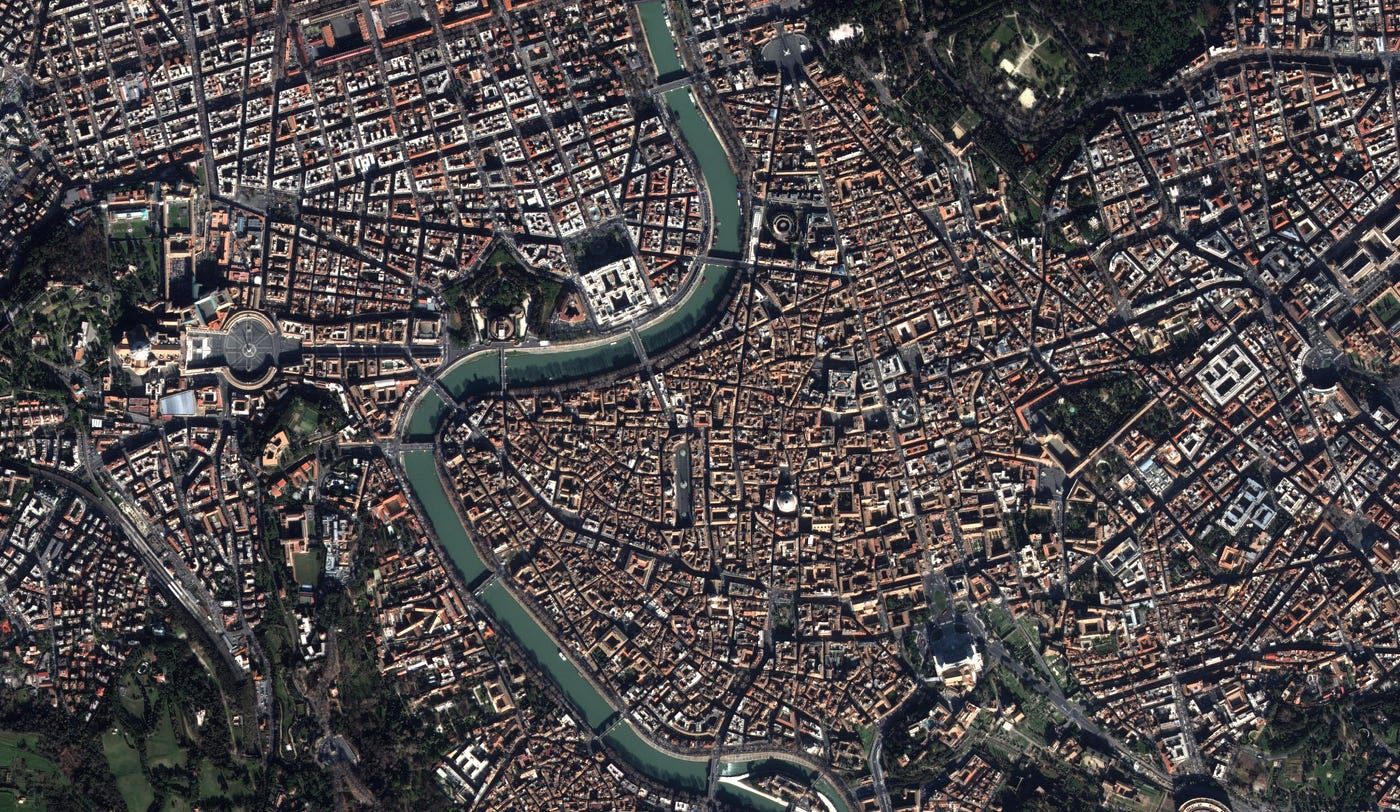


🛰️  PREDICTION RESULT
✅ Predicted: Urban
✅ Confidence: 82.85%
📊 All probabilities:
   Urban: 82.85%
  Forest: 12.95%
   Water: 4.20%

✅ Done. Use menu again.


In [18]:

upload_and_predict()


📤 Upload image(s) now (jpg/png/jpeg)...


Saving water.jpg to water (1).jpg


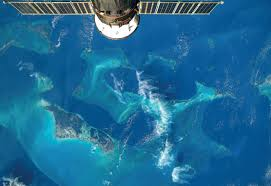


🛰️  PREDICTION RESULT
✅ Predicted: Water
✅ Confidence: 49.92%
📊 All probabilities:
   Urban: 39.65%
  Forest: 10.43%
   Water: 49.92%

✅ Done. Use menu again.


In [20]:

upload_and_predict()


📤 Upload image(s) now (jpg/png/jpeg)...


Saving foress.jpg to foress.jpg


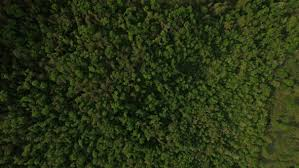


🛰️  PREDICTION RESULT
✅ Predicted: Forest
✅ Confidence: 34.72%
📊 All probabilities:
   Urban: 34.50%
  Forest: 34.72%
   Water: 30.79%

✅ Done. Use menu again.


In [23]:

upload_and_predict()
